# Project Statement

The Film Junky Union, a new edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. The goal is to train a model to automatically detect negative reviews. You'll be using a dataset of IMBD movie reviews with polarity labelling to build a model for classifying positive and negative reviews. It will need to have an F1 score of at least 0.85.

## Initialization

In [1]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [2]:
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

from tqdm.auto import tqdm

from sklearn.metrics import confusion_matrix, classification_report

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

# plt.style.available
plt.style.use('seaborn-v0_8-pastel')


In [3]:
# this is to use progress_apply, read more at https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

`data import`

In [4]:
try:
    df_reviews = pd.read_csv('/kaggle/input/imdb-data/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})
    
except:
    df_reviews = pd.read_csv('/Users/dani/Data Science/TripleTen Projects/Project Data/ML for Text/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})


`data review`

In [5]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

In [6]:
df_reviews.describe()

,start_year,is_adult,average_rating,votes,rating,pos,idx
count,47331.000000,47331.000000,47329.000000,47329.0,47331.000000,47331.000000,47331.000000
mean,1989.631235,0.001732,5.998278,25562.917323,5.484608,0.498954,6279.697999
std,19.600364,0.041587,1.494289,83670.039163,3.473109,0.500004,3605.702545
min,1894.000000,0.000000,1.400000,9.0,1.000000,0.000000,0.000000
25%,1982.000000,0.000000,5.100000,827.0,2.000000,0.000000,3162.000000
50%,1998.000000,0.000000,6.300000,3197.0,4.000000,0.000000,6299.000000
75%,2004.000000,0.000000,7.100000,13974.0,9.000000,1.000000,9412.000000
max,2010.000000,1.000000,9.700000,1739448.0,10.000000,1.000000,12499.000000


In [7]:
display(df_reviews[df_reviews.isnull().any(axis=1)])

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
22280,tt0192317,movie,Mila Ass Painting,Mila Ass Painting,1998,\N,\N,0,\N,NaN,<NA>,"This is a truly great film, with excellent dir...",9,pos,1,test,3231
22281,tt0192317,movie,Mila Ass Painting,Mila Ass Painting,1998,\N,\N,0,\N,NaN,<NA>,"A film is beyond all expectations, an excellen...",10,pos,1,test,3232


In [8]:
df_reviews = df_reviews.dropna().copy()

#df_reviews.info()

## EDA

`number of movies and reviews over years`

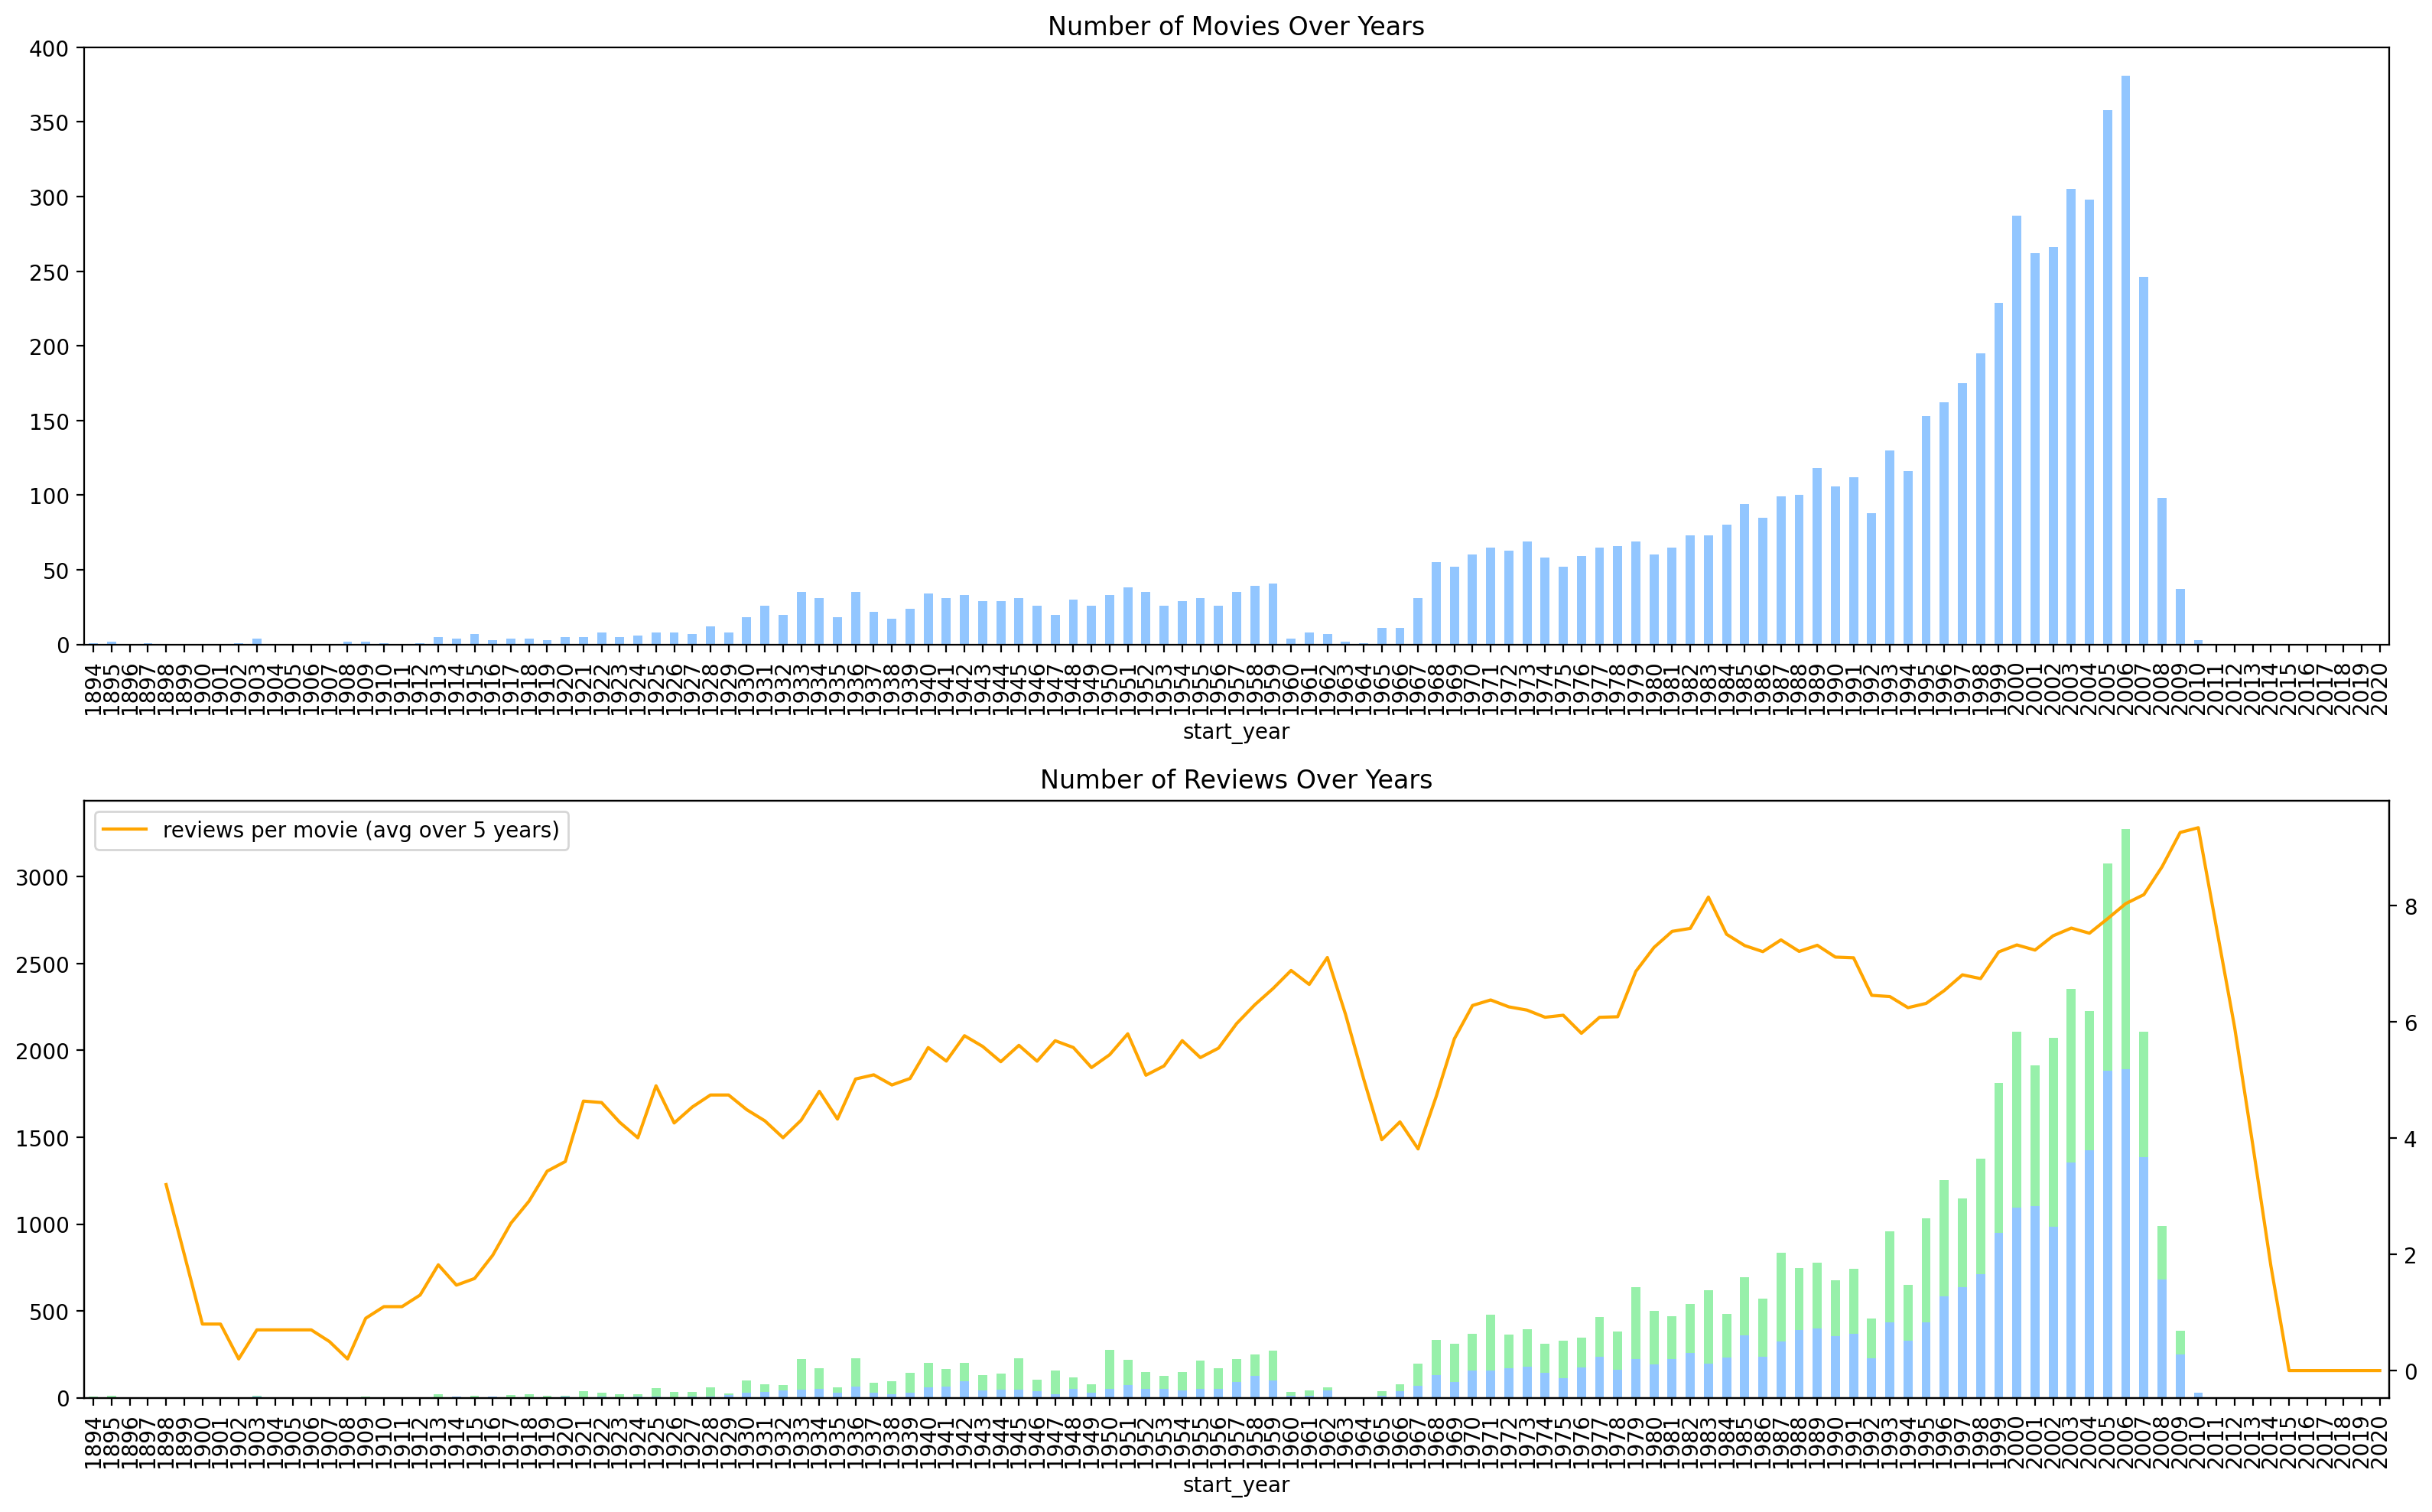

In [9]:
fig, axs = plt.subplots(2, 1, figsize=(16, 10))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years')
# ax.legend(['Negative', 'Positive']) # addition

fig.tight_layout()

`distribution of number of reviews per movie with the exact counting and KDE (just to learn how it may differ from the exact counting)`

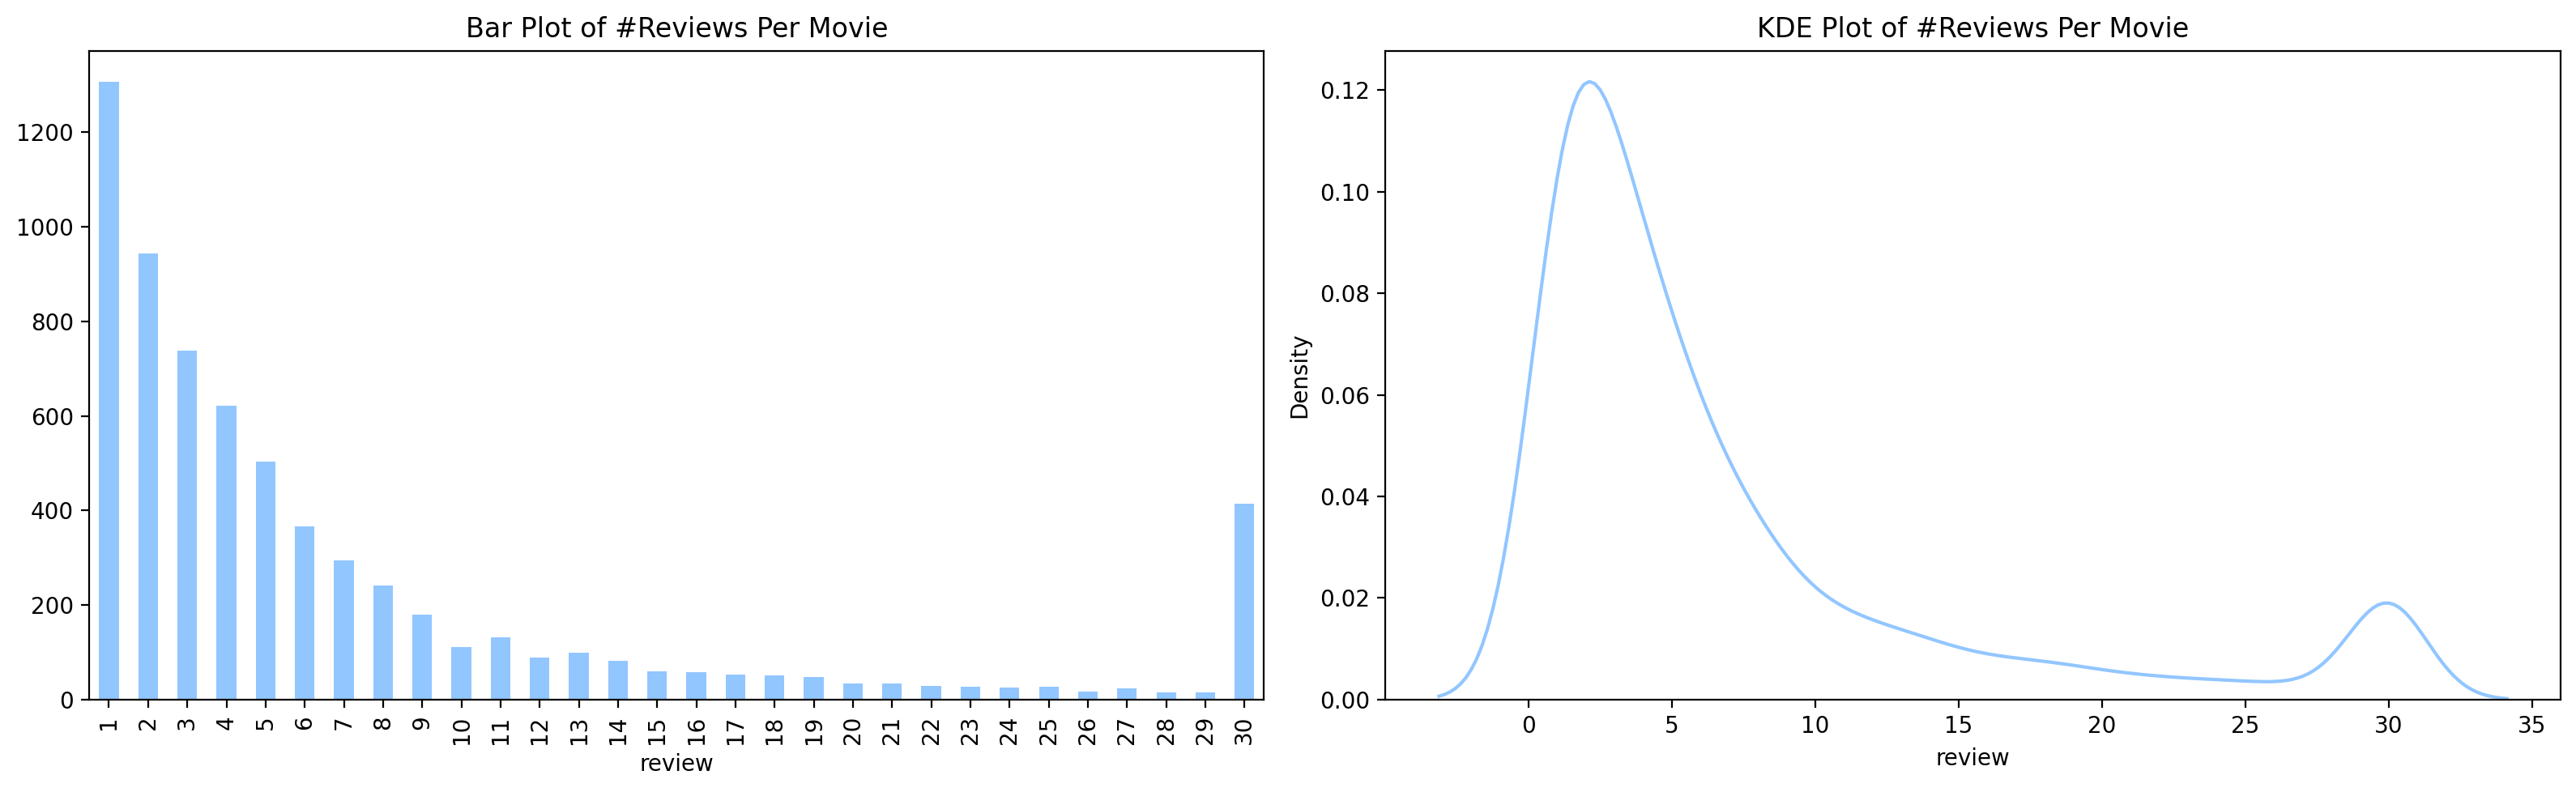

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout()

**`Findings`**

From our top 2 charts above, we see a large upwards trend in the number of reviews per movie starting in the early 1990s as the VHS format was becoming more accessible/economic and DVDs were introduced into the market (1996). 

Our bottom 2 charts, show us the frequency of reviews per movie. We see a large concentration of less than 5 reviews per movie with an outlier instance with 30 reviews. This could lead to class imbalancing or another type of 'skewness' depending on the type of review (negative vs positive).

In [11]:
df_reviews['pos'].value_counts() # class imbalance seems negligible at first glance

pos
0    23715
1    23614
Name: count, dtype: int64

`pos`: the target, '0' for negative and '1' for positive

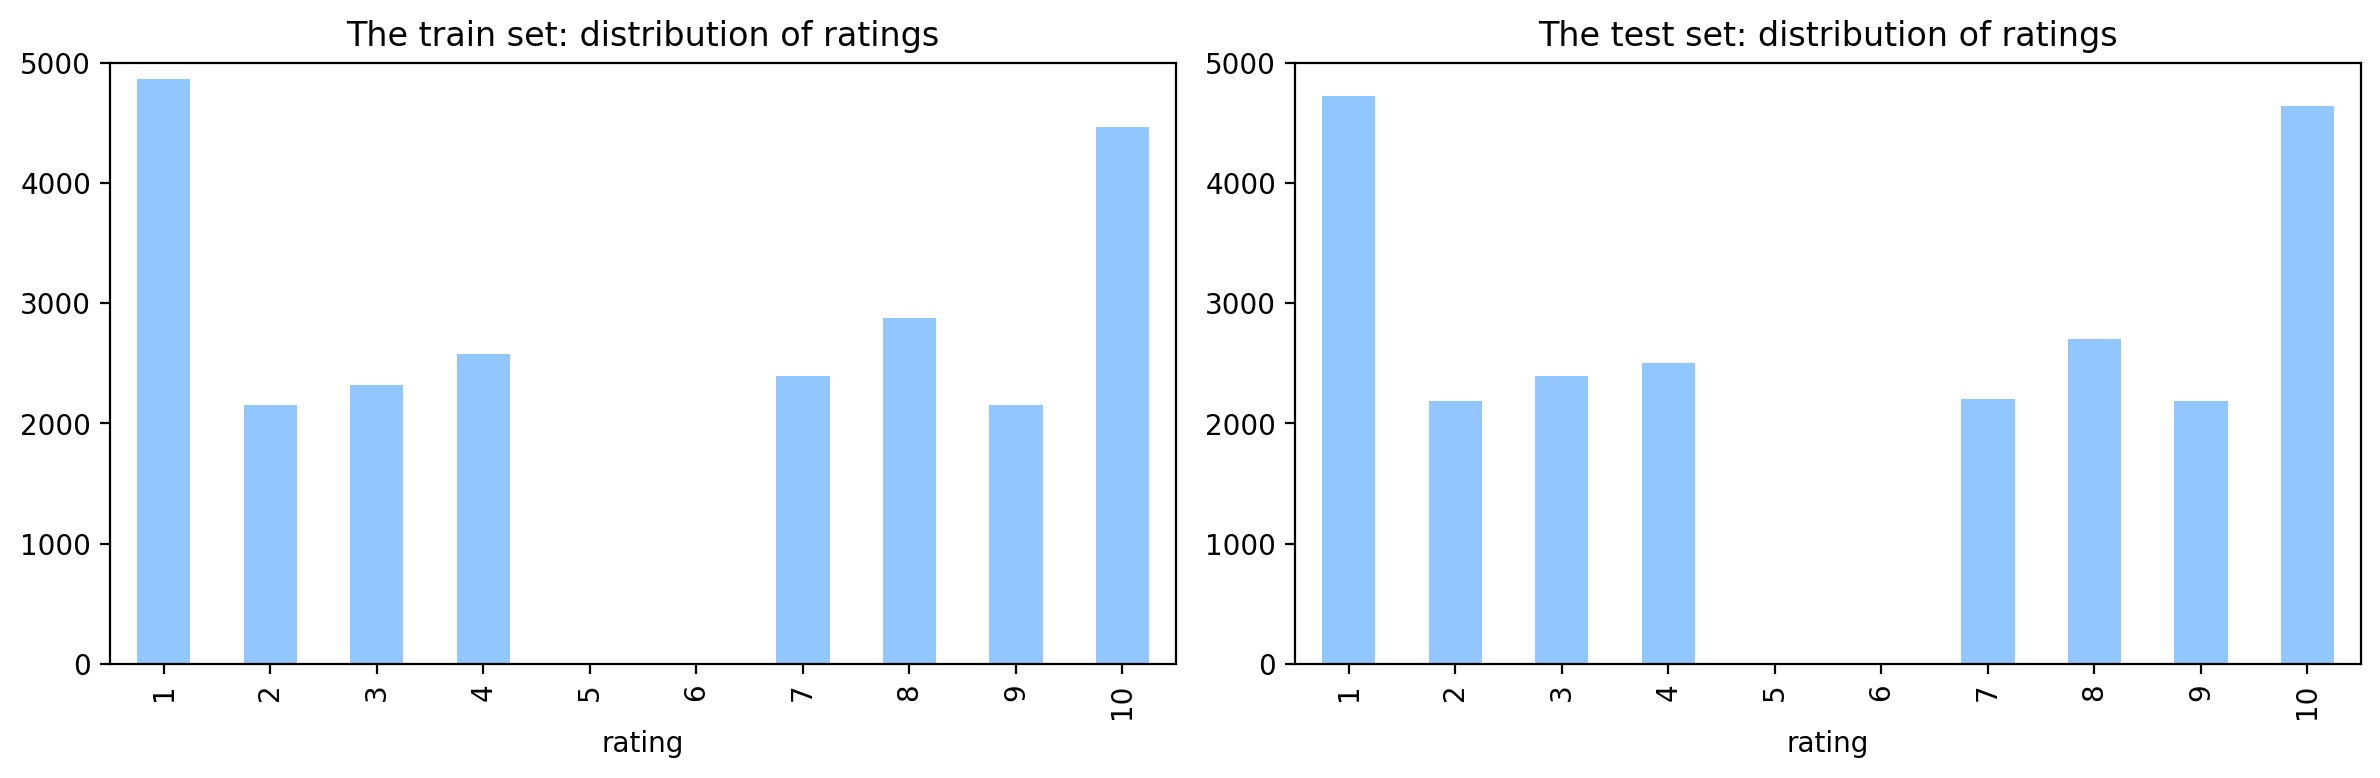

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()

In [13]:
df_reviews.query('ds_part == "train"')['pos'].value_counts() # 50.1% negative

pos
0    11912
1    11884
Name: count, dtype: int64

In [14]:
df_reviews.query('ds_part == "test"')['pos'].value_counts() # 50.2% negative

pos
0    11803
1    11730
Name: count, dtype: int64

`distribution of negative and positive reviews over the years for two parts of the dataset`

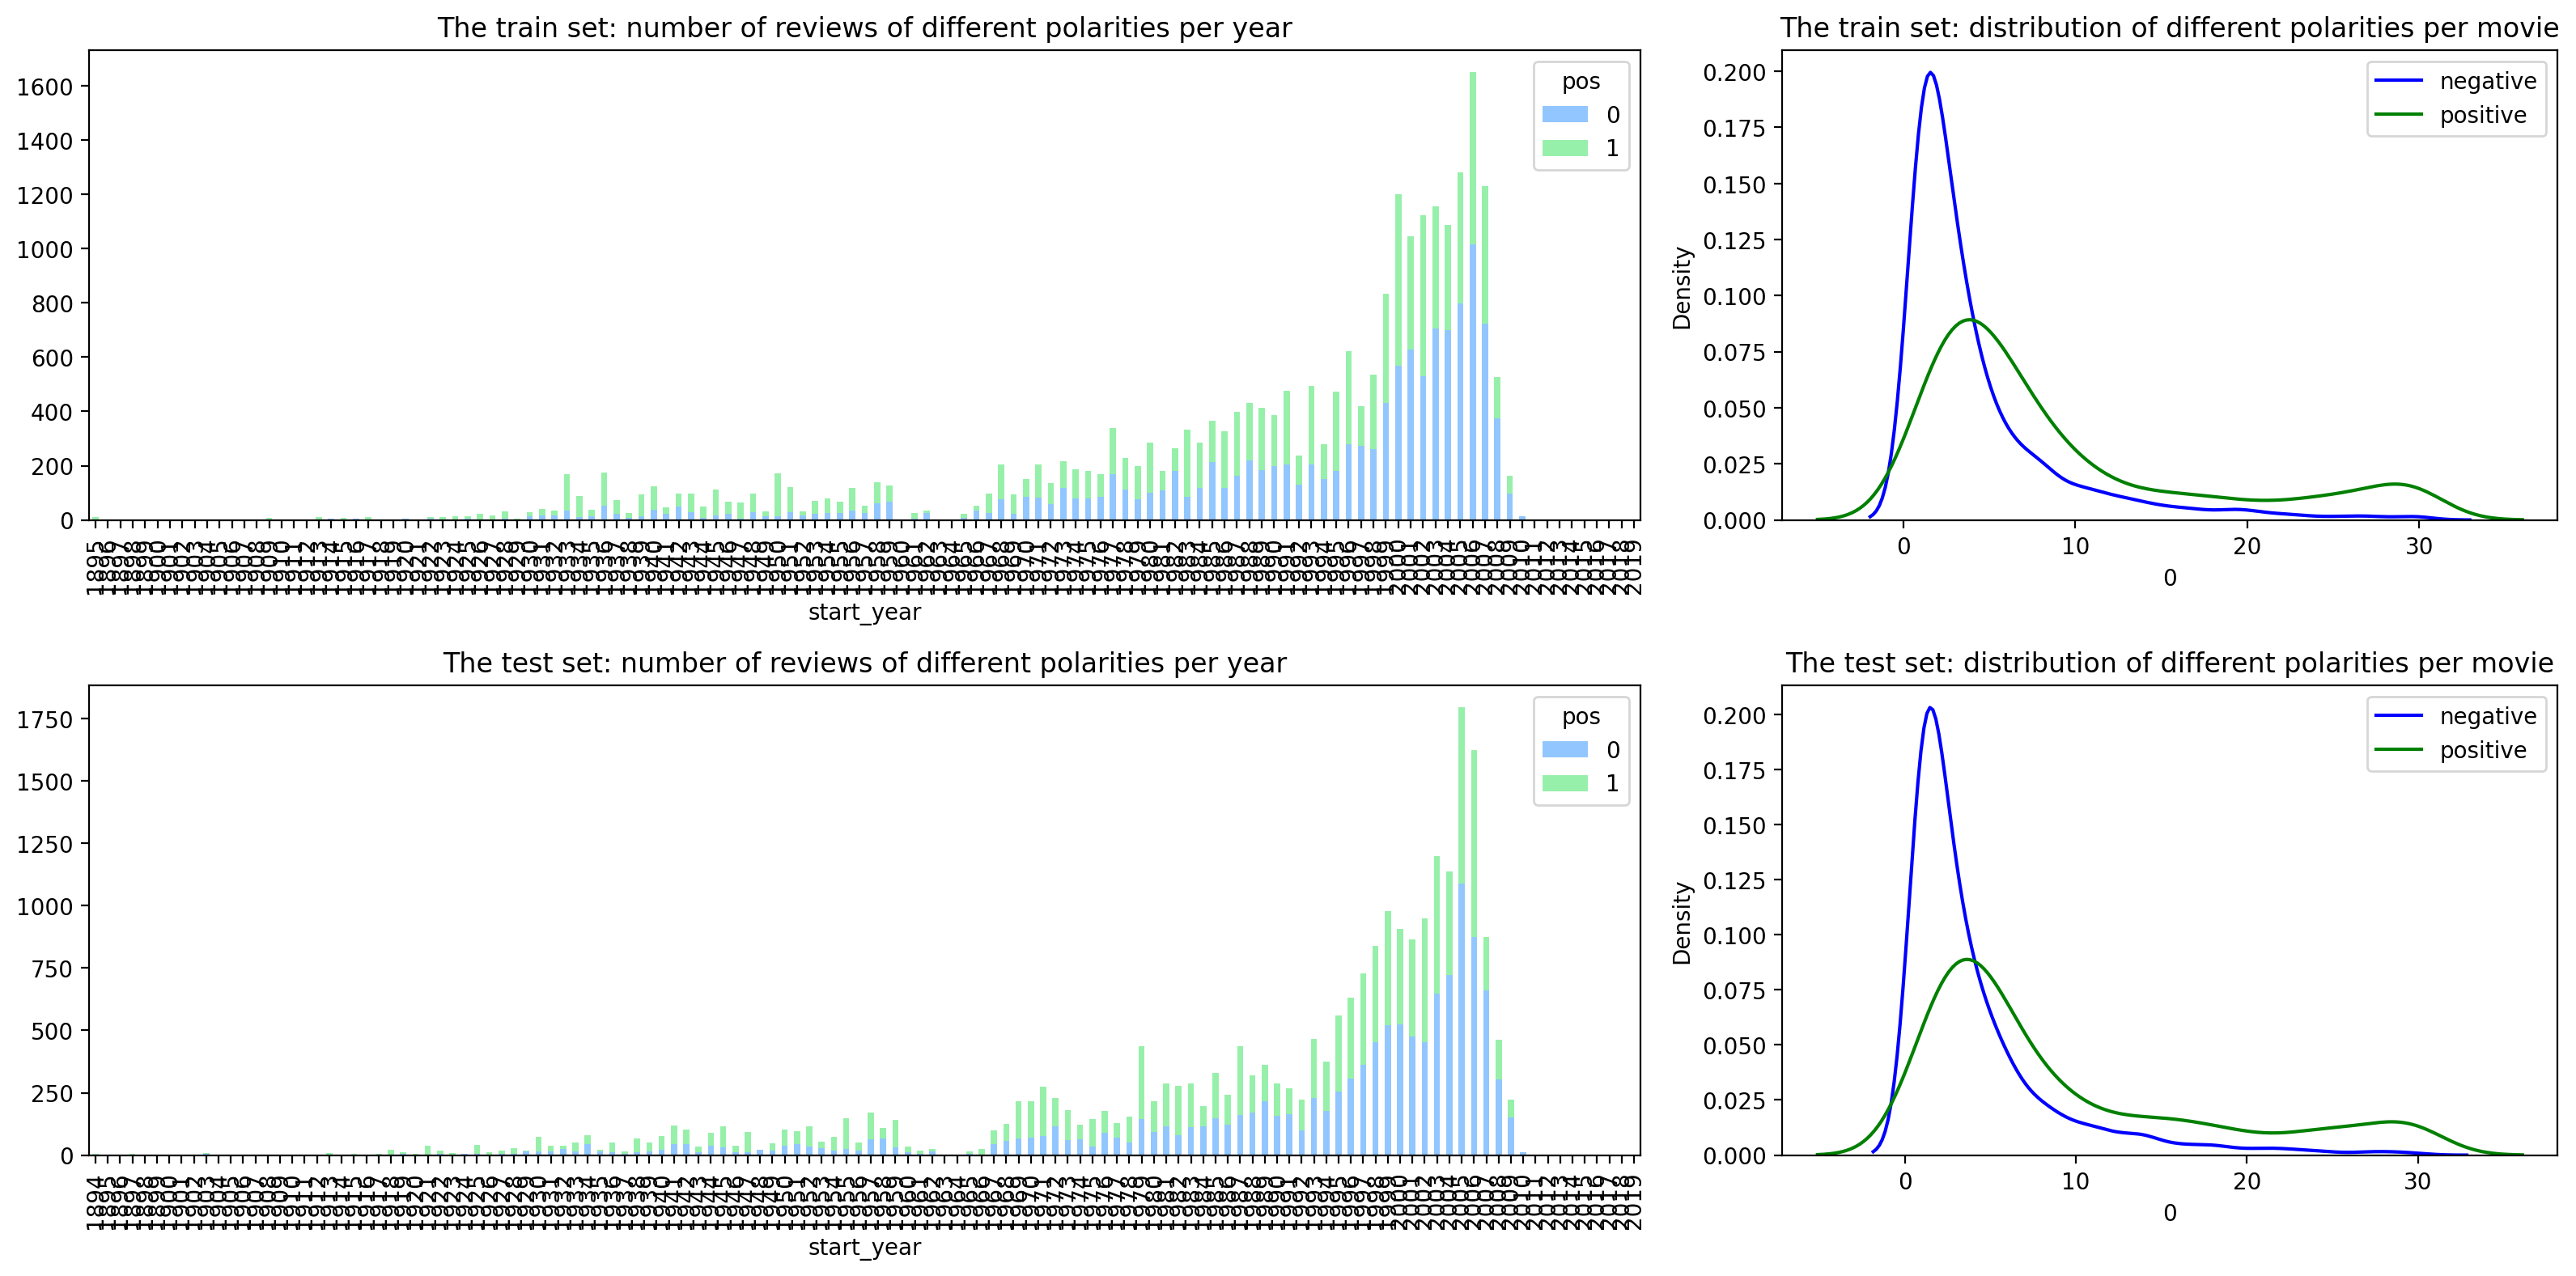

In [15]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

**`Findings`**

Visualizing our train and test set rating distributions lets us verify the expected similarities in both the distribution of ratings and the accompanying polarities.

### Evaluation Procedure

`composing an evaluation routine which can be used for all models in this project`

In [16]:
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

### Normalization

`assuming all models below accepts texts in lowercase and without any digits, punctuations marks etc.`

In [17]:
import re

In [18]:
def normalize(review):
    pattern = r"[^a-zA-Z' ]"
    review = re.sub(pattern, '', review)
    
    return " ".join(review.split())


df_reviews['review_norm'] = df_reviews['review'].apply(normalize) # clearing text to remove digits, punctuation marks, double spacing, etc..

`data splitting`

*the whole dataset is already divided into train/test one parts. The corresponding flag is 'ds_part'.*

In [19]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23533, 18)


In [20]:
corpus_train = df_reviews_train['review_norm']
corpus_test = df_reviews_test['review_norm']

In [21]:
random_state = 12345 # constant random_state value to apply to all models

## Data Modeling

`Model 0 - Constant`

In [22]:
from sklearn.dummy import DummyClassifier

In [23]:
strategies = ['most_frequent', 'stratified', 'uniform', 'constant'] 
  
test_scores = [] 
for s in strategies: 
    if s =='constant': 
        dummy_model = DummyClassifier(strategy = s, random_state = random_state, constant = 0) 
    else: 
        dummy_model = DummyClassifier(strategy = s, random_state = random_state) 
    dummy_model.fit(corpus_train, train_target) 
    score = dummy_model.score(corpus_test, test_target) 
    test_scores.append(score)

In [24]:
# ax = sns.stripplot(strategies, test_scores); 
# ax.set(xlabel ='Strategy', ylabel ='Test Score - Negative Reviews') 
# plt.show() 

# achieved the same results while leveraging the lemmatized/transformed train/test corpus and their respective features

`Model 1 - NLTK, TF-IDF and LR`

*TF-IDF*

In [34]:
import nltk
nltk.download('popular')
import subprocess

# downloading and unzipping wordnet
# try:
    # nltk.data.find('wordnet.zip')
# except:
#     nltk.download('wordnet', download_dir='/kaggle/working/')
#     command = "unzip /kaggle/working/corpora/wordnet.zip -d /kaggle/working/corpora"
#     subprocess.run(command.split())
#     nltk.data.path.append('/kaggle/working/')

# NLTK resources
from nltk.corpus import wordnet

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to
[nltk_data]    |     /Users/dani/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package gazetteers to
[nltk_data]    |     /Users/dani/nltk_data...
[nltk_data]    |   Unzipping corpora/gazetteers.zip.
[nltk_data]    | Downloading package genesis to
[nltk_data]    |     /Users/dani/nltk_data...
[nltk_data]    |   Unzipping corpora/genesis.zip.
[nltk_data]    | Downloading package gutenberg to
[nltk_data]    |     /Users/dani/nltk_data...
[nltk_data]    |   Unzipping corpora/gutenberg.zip.
[nltk_data]    | Downloading package inaugural to
[nltk_data]    |     /Users/dani/nltk_data...
[nltk_data]    |   Unzipping corpora/inaugural.zip.
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /Users/dani/nltk_data...
[nltk_data]    |   Unzipping corpora/movie_reviews.zip.
[nltk_data]    | Downloading package names to /

In [35]:
nltk.download('stopwords')
# nltk.download('all-corpora')
# nltk.download('all')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package stopwords to /Users/dani/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [36]:
lemmatizer  = WordNetLemmatizer() 

In [37]:
def lemmatize(review):

    tokens = word_tokenize(review.lower())
    lemmas = [lemmatizer.lemmatize(token) for token in tokens]
    
    return " ".join(lemmas)

In [38]:
lr_corpus_train = corpus_train.apply(lemmatize) # applying the nltk lemmatize function to our normalized review data

lr_corpus_test = corpus_test.apply(lemmatize) # applying the nltk lemmatize function to our normalized review data

In [39]:
from spacy.lang.de.stop_words import STOP_WORDS

# stop_words = set(stopwords.words('english'))
count_tf_idf = TfidfVectorizer(stop_words = list(STOP_WORDS))

In [40]:
tf_idf = count_tf_idf.fit_transform(lr_corpus_train) # transforming our text corpus via TfidVectorizer

In [41]:
train_features_1 = tf_idf # training feature
test_features_1 = count_tf_idf.transform(lr_corpus_test) # test feature

In [42]:
model_1 = LogisticRegression(random_state=random_state)
model_1.fit(train_features_1, train_target) # model training

LogisticRegression(random_state=12345)

          train  test
Accuracy   0.93  0.88
F1         0.93  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


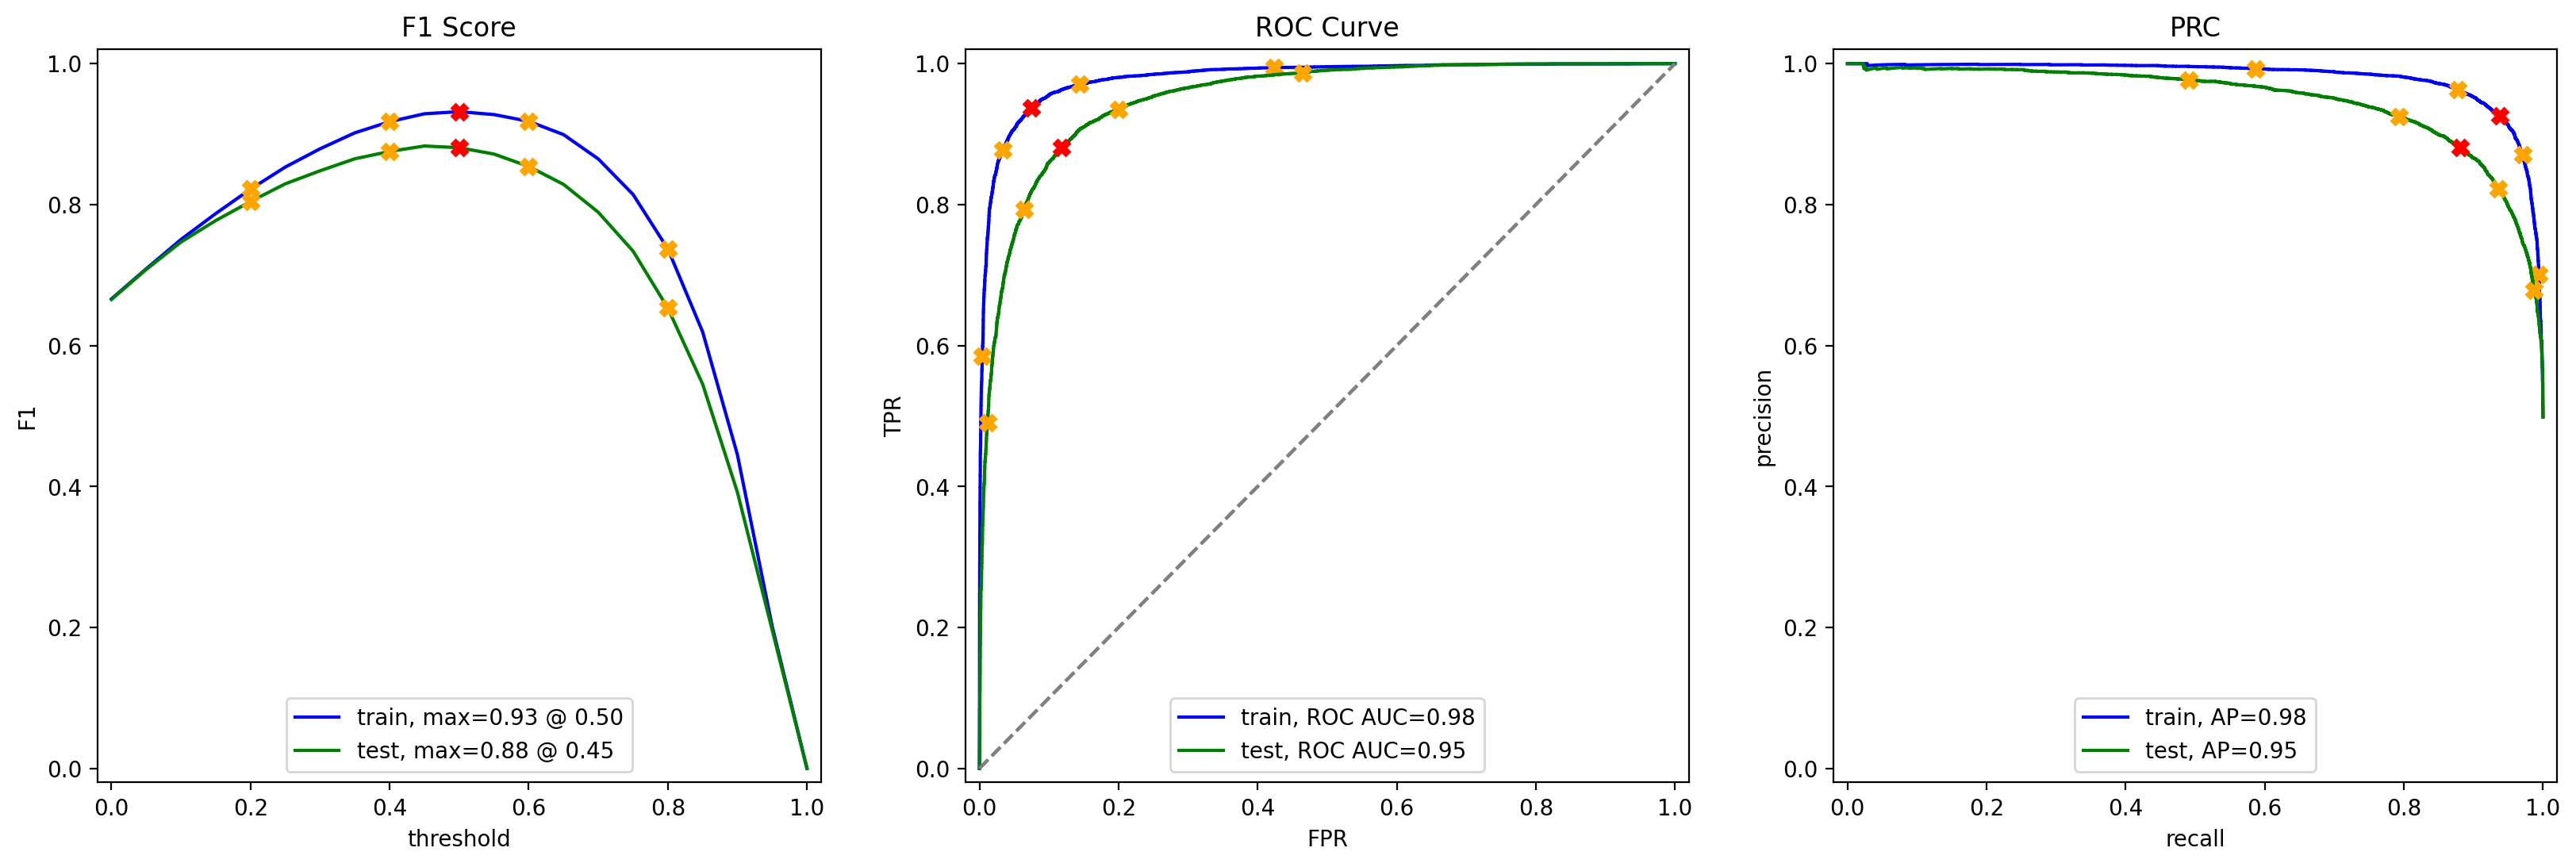

In [43]:
evaluate_model(model_1, train_features_1, train_target, test_features_1, test_target) # model evaluation

In [44]:
model_1_predict = model_1.predict(test_features_1)

print(classification_report(test_target, model_1_predict))

              precision    recall  f1-score   support

           0       0.88      0.88      0.88     11803
           1       0.88      0.88      0.88     11730

    accuracy                           0.88     23533
   macro avg       0.88      0.88      0.88     23533
weighted avg       0.88      0.88      0.88     23533



`Model 2 - spaCy, TF-IDF and LR`

In [53]:
import spacy
# import en_core_web_sm

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
nlp.add_pipe('sentencizer')

In [54]:
def text_preprocessing_spacy(review):
    
    doc = nlp(review.lower())
    # tokens = [token.lemma_ for token in doc if not token.is_stop]
    lemmas = []    
    for token in doc:
        lemmas.append(token.lemma_)
    # lemmas = [token.lemma_ for token in doc if token.is_alpha and not token.is_stop]
    
    return ' '.join(lemmas)

In [55]:
lr_corpus_train_spacy = corpus_train.apply(text_preprocessing_spacy) # applying the spaCy lemmatize/processing function to our normalized review data

lr_corpus_test_spacy = corpus_test.apply(text_preprocessing_spacy) # applying the spaCy lemmatize/processing function to our normalized review data

In [56]:
count_tf_idf_2 = TfidfVectorizer(stop_words = list(STOP_WORDS))

train_features_spacy = count_tf_idf_2.fit_transform(lr_corpus_train_spacy) # 
test_features_spacy = count_tf_idf_2.transform(lr_corpus_test_spacy)

In [57]:
model_2 = LogisticRegression(random_state=random_state)
model_2.fit(train_features_spacy, train_target)

LogisticRegression(random_state=12345)

          train  test
Accuracy   0.93  0.88
F1         0.93  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


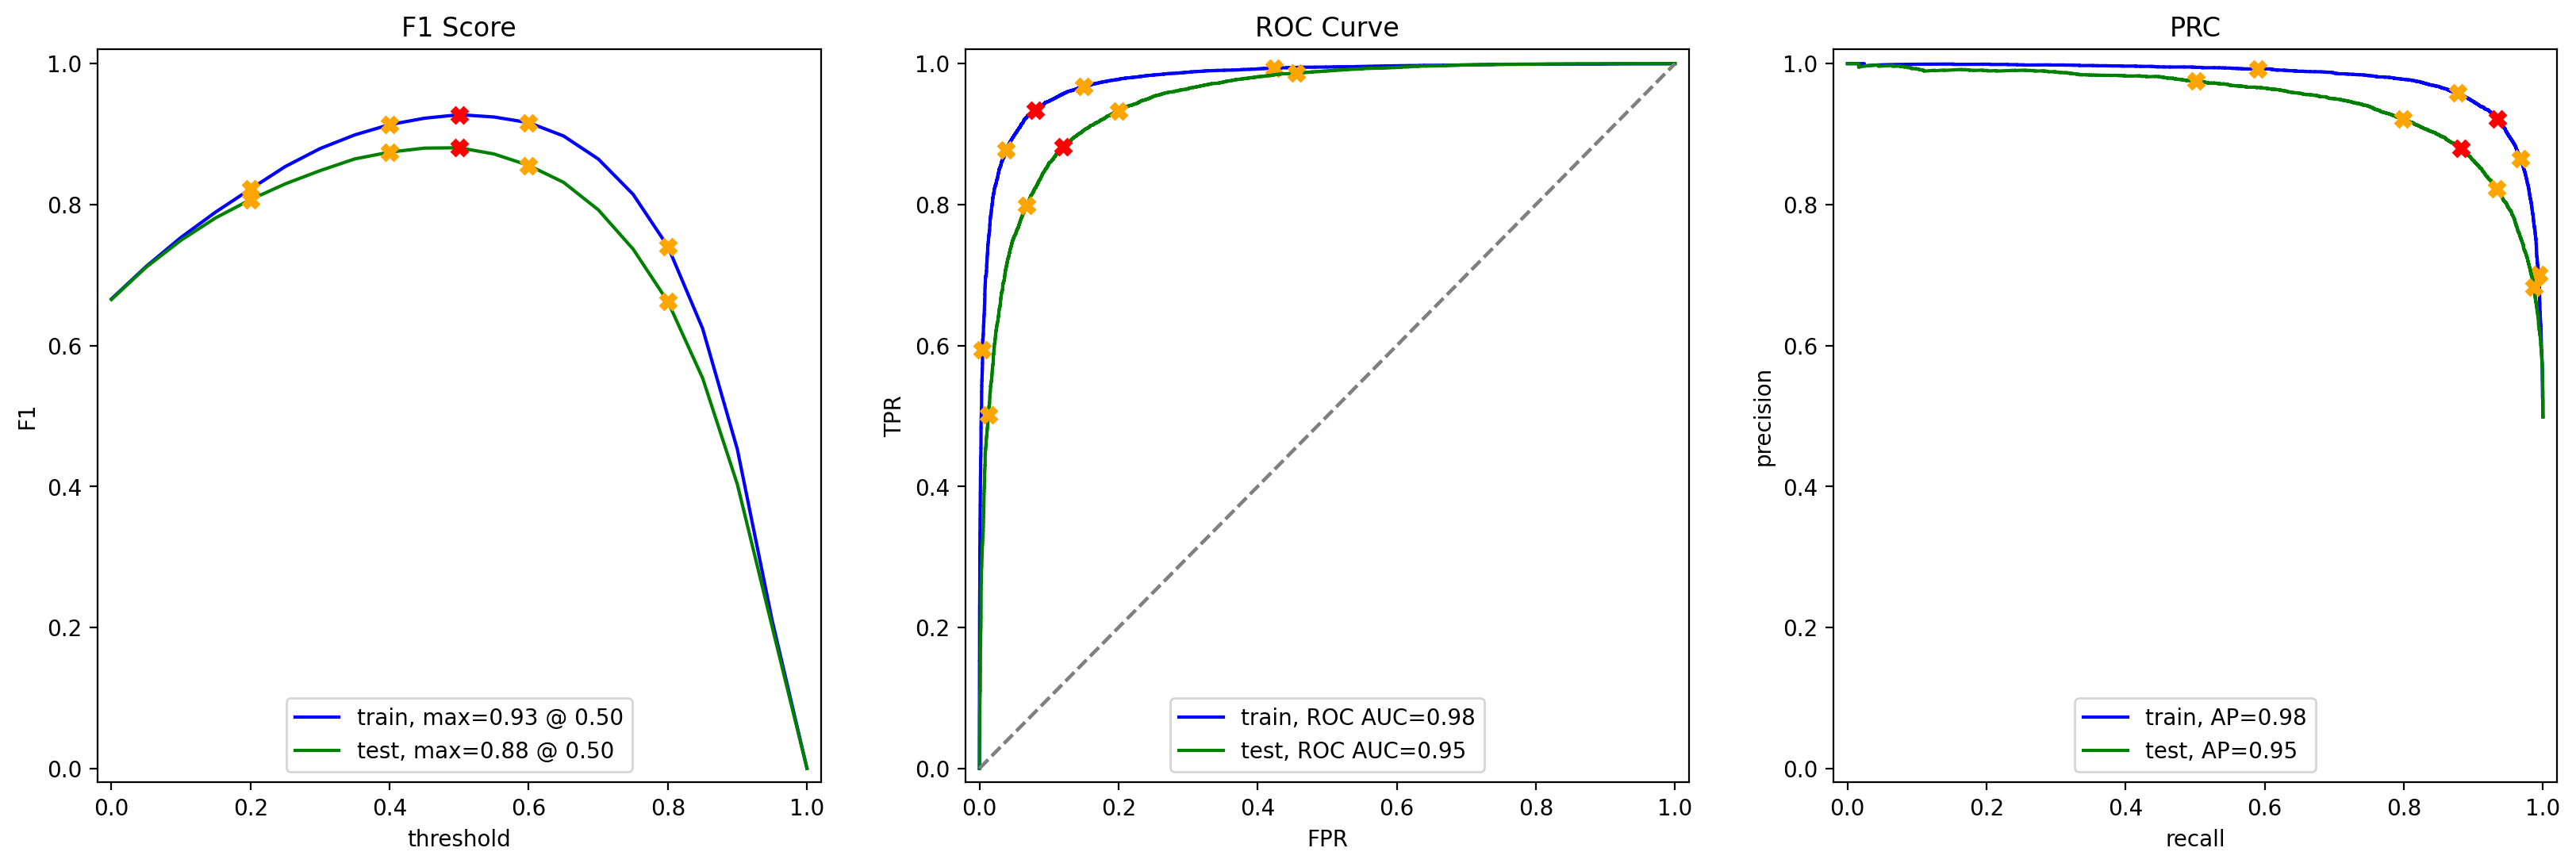

In [60]:
evaluate_model(model_2, train_features_spacy, train_target, test_features_spacy, test_target)

In [61]:
model_2_predict = model_2.predict(test_features_spacy)

print(classification_report(test_target, model_2_predict))

              precision    recall  f1-score   support

           0       0.88      0.88      0.88     11803
           1       0.88      0.88      0.88     11730

    accuracy                           0.88     23533
   macro avg       0.88      0.88      0.88     23533
weighted avg       0.88      0.88      0.88     23533



`Model 3 - spaCy, TF-IDF and LGBMClassifier`

In [62]:
from lightgbm import LGBMClassifier

In [63]:
model_3 = LGBMClassifier(random_state=random_state)
model_3.fit(train_features_spacy, train_target) # model training

[LightGBM] [Info] Number of positive: 11884, number of negative: 11912
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.399849 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 468616
[LightGBM] [Info] Number of data points in the train set: 23796, number of used features: 9416
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499412 -> initscore=-0.002353
[LightGBM] [Info] Start training from score -0.002353


LGBMClassifier(random_state=12345)

          train  test
Accuracy   0.92  0.86
F1         0.92  0.86
APS        0.98  0.93
ROC AUC    0.98  0.94


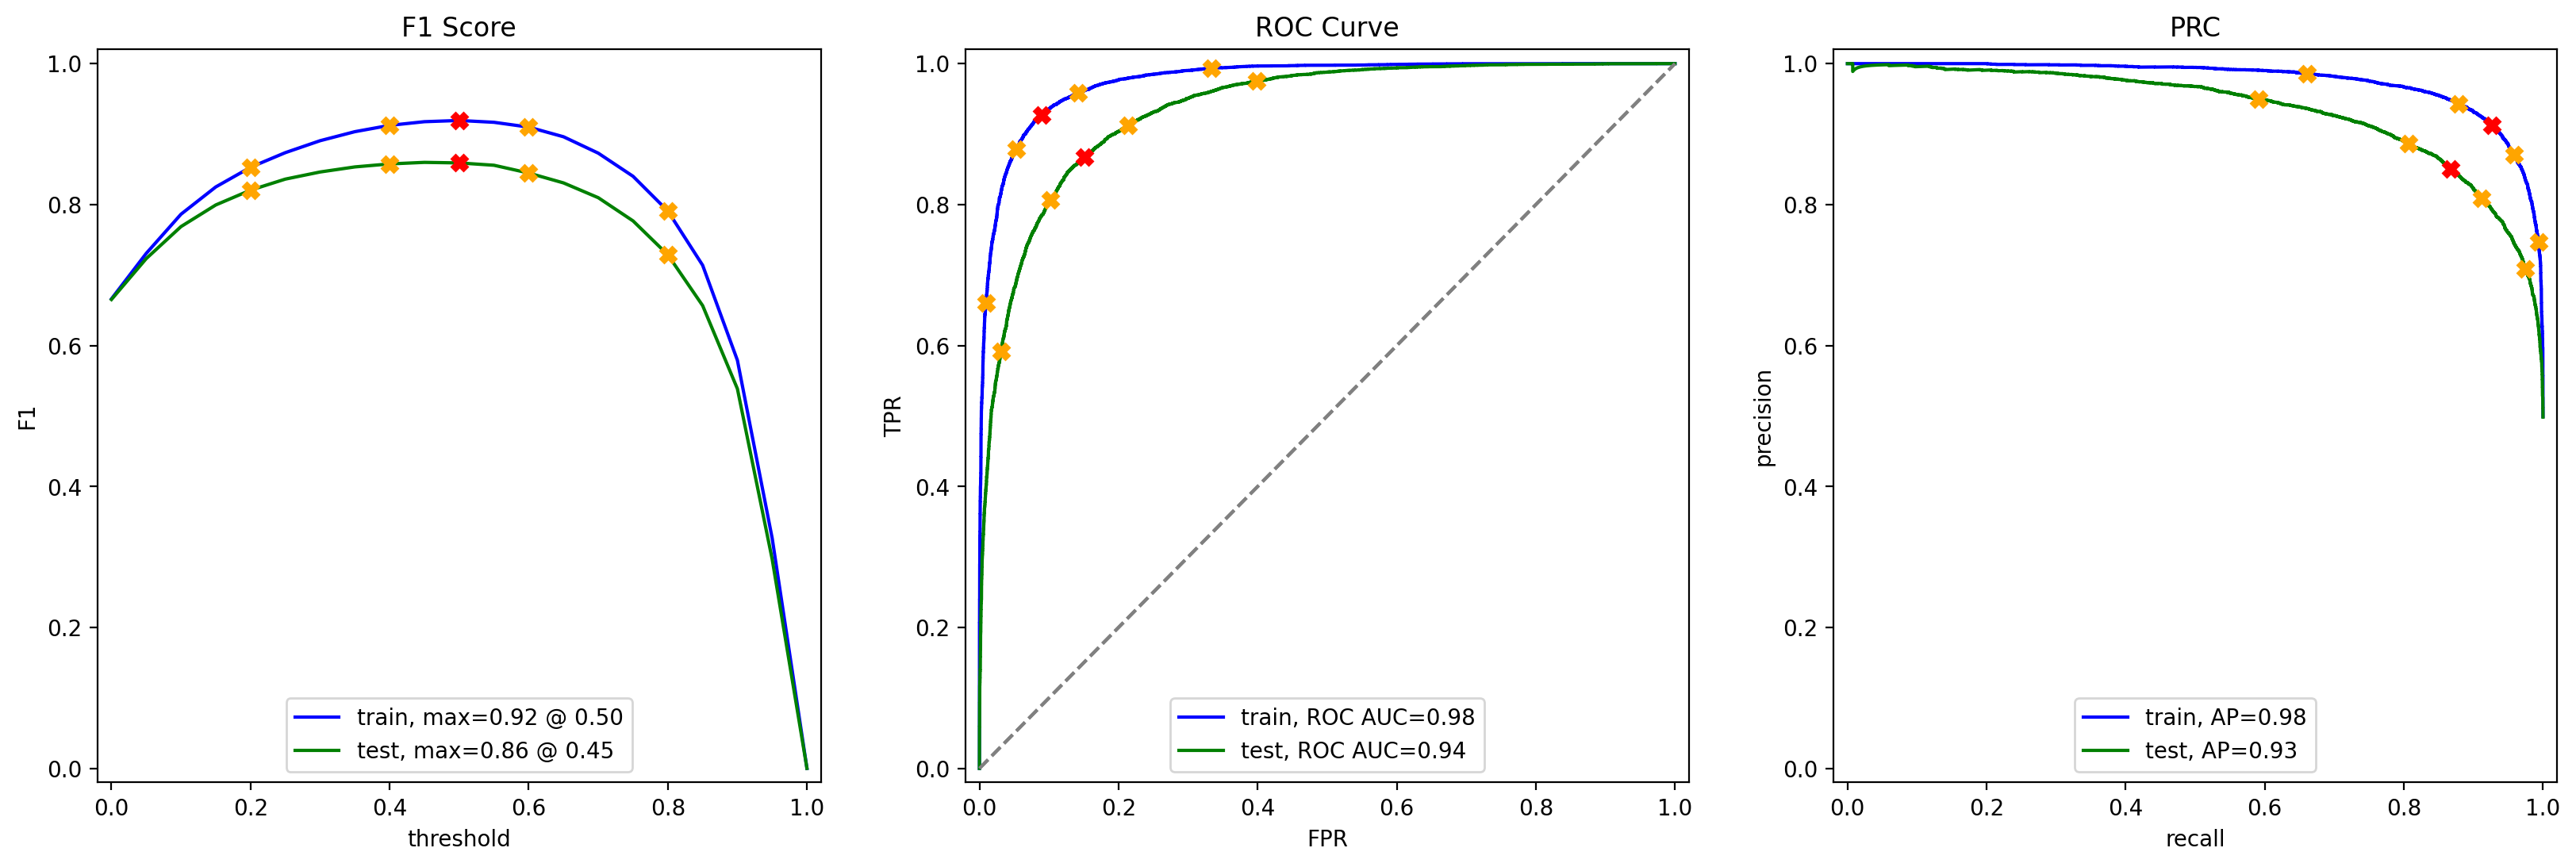

In [64]:
evaluate_model(model_3, train_features_spacy, train_target, test_features_spacy, test_target) # evaluation

In [65]:
model_3_predict = model_3.predict(test_features_spacy)

print(classification_report(test_target, model_3_predict))

              precision    recall  f1-score   support

           0       0.87      0.85      0.86     11803
           1       0.85      0.87      0.86     11730

    accuracy                           0.86     23533
   macro avg       0.86      0.86      0.86     23533
weighted avg       0.86      0.86      0.86     23533



`Model 9 - BERT` 
*to be completed at a later date due to GPU constraints*

In [66]:
# import torch
# import transformers

In [67]:
# tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
# config = transformers.BertConfig.from_pretrained('bert-base-uncased')
# model = transformers.BertModel.from_pretrained('bert-base-uncased')

In [68]:
# def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):
    
#     ids_list = []
#     attention_mask_list = []

#     # text to padded ids of tokens along with their attention masks
    
#     # <put your code here to create ids_list and attention_mask_list>
    
#     if force_device is not None:
#         device = torch.device(force_device)
#     else:
#         device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
#     model.to(device)
#     if not disable_progress_bar:
#         print(f'Using the {device} device.')
    
#     # gettings embeddings in batches

#     embeddings = []

#     for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):
            
#         ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
#         # <put your code here to create attention_mask_batch
            
#         with torch.no_grad():            
#             model.eval()
#             batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)   
#         embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())
        
#     return np.concatenate(embeddings)

In [69]:
# # Attention! Running BERT for thousands of texts may take long run on CPU, at least several hours
# train_features_9 = BERT_text_to_embeddings(df_reviews_train['review_norm'], force_device='cuda')

In [70]:
# print(df_reviews_train['review_norm'].shape)
# print(train_features_9.shape)
# print(train_target.shape)

In [71]:
# if you have got the embeddings, it's advisable to save them to have them ready if 
# np.savez_compressed('features_9.npz', train_features_9=train_features_9, test_features_9=test_features_9)

# and load...
# with np.load('features_9.npz') as data:
#     train_features_9 = data['train_features_9']
#     test_features_9 = data['test_features_9']

## Model application to newly introduced reviews

In [72]:
my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

my_reviews['review_norm'] = my_reviews['review'].apply(normalize)

my_reviews

,review,review_norm
0,"I did not simply like it, not my kind of movie.",I did not simply like it not my kind of movie
1,"Well, I was bored and felt asleep in the middl...",Well I was bored and felt asleep in the middle...
2,I was really fascinated with the movie,I was really fascinated with the movie
3,Even the actors looked really old and disinter...,Even the actors looked really old and disinter...
4,I didn't expect the reboot to be so good! Writ...,I didn't expect the reboot to be so good Write...
5,"The movie had its upsides and downsides, but I...",The movie had its upsides and downsides but I ...
6,What a rotten attempt at a comedy. Not a singl...,What a rotten attempt at a comedy Not a single...
7,Launching on Netflix was a brave move & I real...,Launching on Netflix was a brave move I really...


`Model 1`

In [73]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_1.predict_proba(count_tf_idf.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.14:  I did not simply like it not my kind of movie
0.31:  Well I was bored and felt asleep in the middle of the movie
0.59:  I was really fascinated with the movie
0.20:  Even the actors looked really old and disinterested and they got paid to be in the movie What a soul
0.36:  I didn't expect the reboot to be so good Writers really cared about the source material
0.60:  The movie had its upsides and downsides but I feel like overall it's a decent flick I could see myse
0.10:  What a rotten attempt at a comedy Not a single joke lands everyone acts annoying and loud even kids 
0.83:  Launching on Netflix was a brave move I really appreciate being able to binge on episode after episo


`Model 2`

In [74]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_2.predict_proba(count_tf_idf_2.transform(texts.apply(lambda x: text_preprocessing_spacy(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.17:  I did not simply like it not my kind of movie
0.21:  Well I was bored and felt asleep in the middle of the movie
0.50:  I was really fascinated with the movie
0.16:  Even the actors looked really old and disinterested and they got paid to be in the movie What a soul
0.20:  I didn't expect the reboot to be so good Writers really cared about the source material
0.68:  The movie had its upsides and downsides but I feel like overall it's a decent flick I could see myse
0.03:  What a rotten attempt at a comedy Not a single joke lands everyone acts annoying and loud even kids 
0.87:  Launching on Netflix was a brave move I really appreciate being able to binge on episode after episo


`Model 3`

In [75]:
texts = my_reviews['review_norm']

tfidf_vectorizer_3 = count_tf_idf_2
my_reviews_pred_prob = model_3.predict_proba(tfidf_vectorizer_3.transform(texts.apply(lambda x: text_preprocessing_spacy(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.52:  I did not simply like it not my kind of movie
0.46:  Well I was bored and felt asleep in the middle of the movie
0.64:  I was really fascinated with the movie
0.63:  Even the actors looked really old and disinterested and they got paid to be in the movie What a soul
0.38:  I didn't expect the reboot to be so good Writers really cared about the source material
0.78:  The movie had its upsides and downsides but I feel like overall it's a decent flick I could see myse
0.19:  What a rotten attempt at a comedy Not a single joke lands everyone acts annoying and loud even kids 
0.75:  Launching on Netflix was a brave move I really appreciate being able to binge on episode after episo


`Model 9 - BERT` 
*to be completed at a later date due to GPU constraints*

In [76]:
# texts = my_reviews['review_norm']

# my_reviews_features_9 = BERT_text_to_embeddings(texts, disable_progress_bar=True)

# my_reviews_pred_prob = model_9.predict_proba(my_reviews_features_9)[:, 1]

# for i, review in enumerate(texts.str.slice(0, 100)):
#     print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

## Conclusions

**`General`**

- We initialized a DataFrame with more than 40k+ rows and 15+ colums (plenty with varying dtypes). Given our goal was to apply ML on a set of reviews (IMDB in this instance), a large set of columns were set aside and the main focus was on three specific ones:

    - `review`: the review text

    - `pos`: the target, '0' for negative and '1' for positive

    - `ds_part`: 'train'/'test' for the train/test part of dataset, correspondingly
    

- Through our typical usage of EDA along with deep visualizations, we were able to get a sense of the data structure (mainly our targets and any imbalancing) along with some additional insights (frequency of reviews per movie). We were able to construct an intial view on the polarity of our target and the distribution of ratings. At first glance, this DataFrame did not have many 'errors' or clean-up requirements (aside from a minor number of N/A values, which were removed given the count; 2 or 3 rows which have no real impact in this exercise). 

**Model Training/Evaluations - `Non-BERT`**

- Before initializing our models, we start by defining the way we are to 'normalize' our features (reviews) with the removal of digits, punctuations marks and other things of the sort. This initial clean up sets the stage for us to split the data and create the required train/test text corpus later used in our modeling. 


- We created a dummy model in order to have something to benchmark against and make sure our LR/LBGM models were up to par (better than our dummy).


- Through the use of tokenization and lemmatization via NLTK and spaCy, our achieved F1 scores throughout the 3 models is above our target value of `0.85`. The model with the highest F1 score was our LinearRegression model that used both NLTK and spaCy processing for the tokenization/lemmatization of our review corpus. Scores were as follows:

    - `LR + NLTK`: 0.88

    - `LR + spaCy`: 0.88

    - `LGBM + spaCy`: 0.86
    

- We were able to achieve all of these scores without the need to tune or search for the optimial hyperparameters.


- Lastly and for this exercise, we made the choice of not running the BERT model given we achieve the required scores through LR/LGBM and it would have taken a very, very long time to compute. 

**Classification of `Newly Introduced Reviews`**

- Leveraging our previously created tokenization/lemmatization functions as well as our previously trained models based on a 'train' text corpus, we created our own set of reviews for further model evaluation. This is displayed using the same 'fake' set of reviews through three variations where we compared the probability based on each row/review (probability of a negative vs positive review). 


- Based on our results, we see similarities throughout. For instance, our second to last row with the word 'rotten' get a particular bad proability of being a positive score which makes sense given we associate any instance of the word with a negative review. The probability values through the three evaluations match, this row/review is the lowest value of them all.


- At the opposite spectrum, the same can be said of the last row/review, where we see words like 'brave' and 'appreciate' or 'binge' which we can *usually* associate with a possitive tone. All three evaluations give us a similar value, the highest out of the bunch. With that said, there is some variability on the probability value 'ranking' though the middle rows/reviews, although not very significant. Most likely due to 1) the overall differences between NLTK and spaCy and 2) our use of LGBM for our last evaluation.